In [1]:
import tarfile
import pandas as pd
import h5py 
import glob
import numpy as np
import timeit
import os
import matplotlib.pyplot as plt
import seaborn as sns 

Matplotlib created a temporary config/cache directory at /scratch/slurm-job.1108203/matplotlib-d1gfnfkd because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
path_star = '/cluster/work/grlab/projects/GTEx/rna_gencode32_realign/results'

In [3]:
star_junc = pd.read_csv(os.path.join(path_star, 'junctions_spladder.all_coords.sorted.uniq.tsv.gz'), sep = '\t')

In [4]:
# Table from 
# - github/projects2020_ohsu/eth/debug/debug_false_positives/p20230413_load_graph_and_potential_OV_FP.ipynb
# - github/projects2020_ohsu/eth/debug/debug_false_positives/p20230307_filter_allRF_quality_check_exon1_exon2.ipynb

kmers_filtered = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_22March_order_wany_wAnnot/G_TCGA-25-1319-01A-01R-1565-13_SampleLim0.0CohortLimNoneAcrossNone_FiltNormalsGtexCohortCohortlim0.0Across1metadata-spladder.tsv.gz'
df_filtered = pd.read_csv(kmers_filtered)
df_filtered.head()

,kmer,gtexCohortfilter >0.0,gtexCohortfilter >=1.0,gtexCohortfilter >=2.0,gtexCohortfilter >=3.0,gtexCohortfilter >=5.0,gtexCohortfilter >=10.0,coord,junctionAnnotated,readFrameAnnotated,...,strand,junction_coordinate,coordinate_in_GTEX,gtexExon1<cancExon1,gtexExon2<cancExon2,info_not_available,index,shared_across_labs,spladder_info,number_samples_expr
0,LKFLYSRPI,NaN,NaN,NaN,NaN,NaN,NaN,1997343:1997348:1993163:1993176:1993078:1993087,True,True,...,-,1993176:1997343:1993163:1993087,False,False,False,False,0,True,NaN,NaN
1,NGLLSTLQK,NaN,NaN,NaN,NaN,NaN,NaN,102905319:102905325:102908697:102908718:None:None,False,False,...,+,102905325:102908697,False,False,False,False,1,True,NaN,NaN
2,TASYNGLLS,NaN,NaN,NaN,NaN,NaN,NaN,102905307:102905325:102908697:102908706:None:None,False,False,...,+,102905325:102908697,False,False,False,False,2,True,NaN,NaN
3,TLMAQMASG,NaN,NaN,NaN,NaN,NaN,NaN,102044321:102044332:102044477:102044493:None:None,False,False,...,+,102044332:102044477,not_available,not_available,not_available,True,3,True,NaN,NaN
4,ASYNGLLST,NaN,NaN,NaN,NaN,NaN,NaN,102905310:102905325:102908697:102908709:None:None,False,False,...,+,102905325:102908697,False,False,False,False,4,True,NaN,NaN


# Analysis

In [5]:
def query_junction_in_star(junction_start, junction_end, star_junc, verbose=False):
    n_samples = None
    
    # If junction in graph 
    jx_in_star = star_junc.loc[(star_junc['junction_start'] == junction_start) & (star_junc['junction_end'] == junction_end)]

    if jx_in_star.shape[0]:
        # Get the chromosome number 
        if len(set(jx_in_star['chr'].values)) != 1:
            display(jx_in_star)
            print(junction_start, junction_end)
        chrm = jx_in_star['chr'].values[0]
            

        # Open the chromosome file
        projected_chr_file = os.path.join(path_star, f'junctions_spladder_projected/junctions_spladder.projected.{chrm}.hdf5')
        star_expr = h5py.File(projected_chr_file, 'r')
            

        # Extract junction ID in hdf5 file
        start = timeit.default_timer()
        idx = np.where((junction_start == star_expr[f'{chrm}:{strand}:junction_start'][...]) & 
                (junction_end == star_expr[f'{chrm}:{strand}:junction_end'][...]))[0]
        if len(idx) > 0:
            idx = idx[0]


        # Compute the junction expression
        start = timeit.default_timer()
        n_samples = len(np.where(star_expr[f'{chrm}:{strand}:count'][idx] > 0 )[0])
        elapsed =  timeit.default_timer() - start

        star_expr.close()    
            
        if verbose:
            #display(jx_in_star)
            print(chrm, strand)
            print(f'loading {projected_chr_file}')
            print(junction_start, junction_end)
            print(idx)
            print(elapsed, 'time for sample expression')
            print(n_samples)
            
        return n_samples


In [6]:
#query_junctions = df_filtered.loc[df_filtered['number_samples_expr'].isna()]

In [7]:
#query_junctions = df_filtered.loc[ (~ df_filtered['number_samples_expr'].isna()) & (df_filtered['gtexExon1<cancExon1'] == 'True')].sort_values('number_samples_expr').tail(10)

In [8]:
query_junctions = df_filtered

In [9]:
#TEST
# junction_start = 7311121
# junction_end = 7311351
# assert(junction_start < junction_end)

In [ ]:
jx_test = []
kmer_test = []
n_samples_star = []

for i, row in query_junctions.iterrows():
    if i % 5000 == 0:
        print(f'...{i}')
    jx = row['junction_coordinate'].split(':')
    strand = row['strand']
    if len(jx) == 2:
        # Get junction coordinates
        junction_start, junction_end = np.sort(np.array([int(jx[0]), int(jx[1])]))
        
        # Perform queries 
        jx_test.append( row['junction_coordinate'])
        kmer_test.append( row['kmer'])
        n_samples_star.append(query_junction_in_star(junction_start, junction_end, star_junc))
        
    

...0
...5000


# Interpretations

In [ ]:
### 100 000 will be performed
n_rows = 0
for i, row in query_junctions.iterrows():
    jx = row['junction_coordinate'].split(':')
    if len(jx) == 2:
        n_rows+=1

In [ ]:
res = pd.DataFrame.from_dict({'junction_coordinate': jx_test, 
              'kmer': kmer_test, 
              'star_recurrence': n_samples_star  + [None] })


In [ ]:
res['star_recurrence'].unique()

In [ ]:
df_filtered_info = df_filtered.merge(res, on = ['junction_coordinate', 'kmer'], how = 'right') # do left 

In [ ]:
df_filtered_info.columns

In [ ]:
res_path = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_22March_order_wany_wAnnot/G_TCGA-25-1319-01A-01R-1565-13_SampleLim0.0CohortLimNoneAcrossNone_FiltNormalsGtexCohortCohortlim0.0Across1metadata-spladder-TEST.tsv.gz'
df_filtered_info.to_csv(res_path, index=None, compression='gzip', sep = '\t')

Text(0.5, 1.0, 'Expression OV of junctions not found in GTEX STAR alignements')

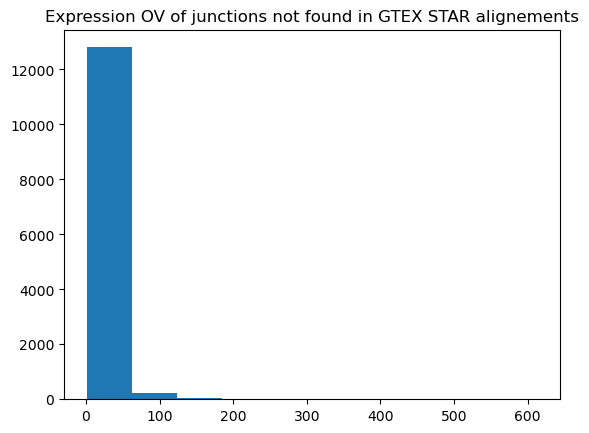

In [25]:
plt.hist(df_filtered_info.loc[df_filtered_info['star_recurrence'].isna(), 'TCGA25131901A01R156513all'])
plt.title('Expression OV of junctions not found in GTEX STAR alignements')

Text(0.5, 1.0, 'Expression OV of junctions found in GTEX STAR alignements')

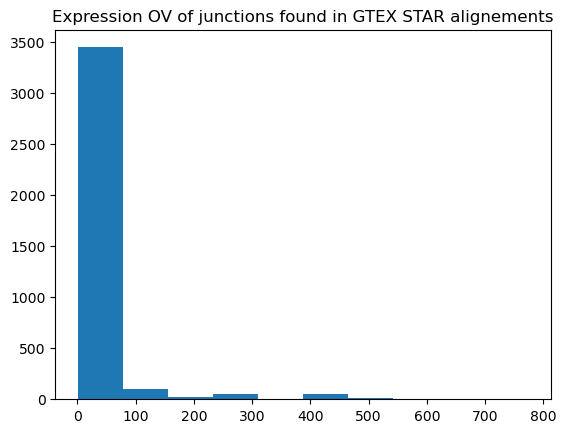

In [26]:
plt.hist(df_filtered_info.loc[~ df_filtered_info['star_recurrence'].isna(), 'TCGA25131901A01R156513all'])
plt.title('Expression OV of junctions found in GTEX STAR alignements')

Text(0.5, 1.0, 'Recurrence OV of junctions found in GTEX STAR alignements')

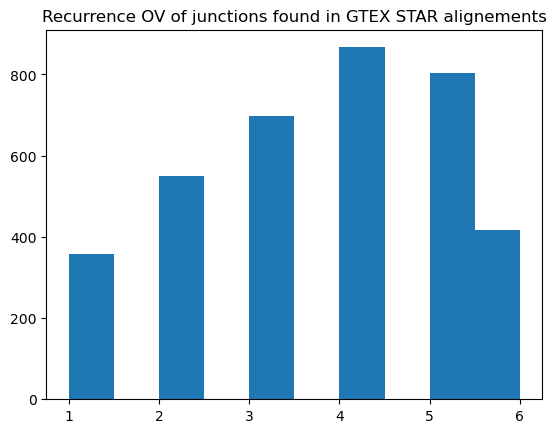

In [28]:
plt.hist(df_filtered_info.loc[~ df_filtered_info['star_recurrence'].isna(), 'cancerCohortfilter >0.0'])
plt.title('Recurrence OV of junctions found in GTEX STAR alignements')

/scratch/slurm-job.1108203/ipykernel_3102069/314501067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['index'] = np.arange(data_plot.shape[0])
/scratch/slurm-job.1108203/ipykernel_3102069/1479295423.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.1108203/ipykernel_3102069/1479295423.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', color=co

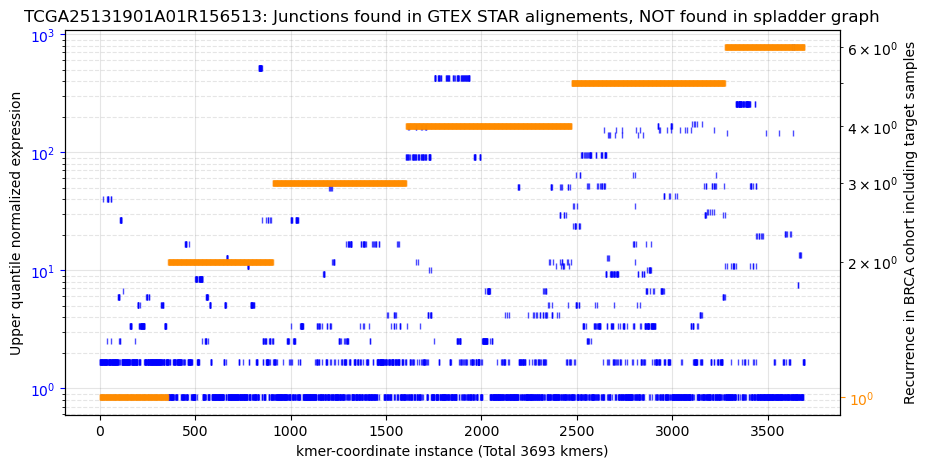

In [75]:
data_plot = df_filtered_info.loc[~ df_filtered_info['star_recurrence'].isna(), :]
expr_col = 'TCGA25131901A01R156513all'
recurr_col = 'cancerCohortfilter >0.0'
data_plot['index'] = np.arange(data_plot.shape[0])
idx = 'index'
sample = expr_col.replace('all','')
title = f'{sample}: Junctions found in GTEX STAR alignements, NOT found in spladder graph'
plot_rec(data_plot, idx, expr_col, recurr_col, title)

/scratch/slurm-job.1108203/ipykernel_3102069/1229457243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['index'] = np.arange(data_plot.shape[0])
/scratch/slurm-job.1108203/ipykernel_3102069/1567863449.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.1108203/ipykernel_3102069/1567863449.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', color=c

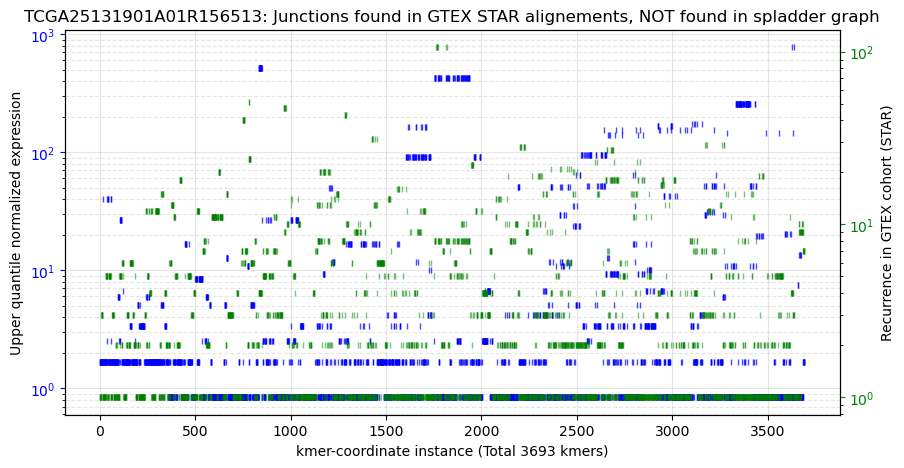

In [76]:
data_plot = df_filtered_info.loc[~ df_filtered_info['star_recurrence'].isna(), :]
expr_col = 'TCGA25131901A01R156513all'
recurr_col = 'star_recurrence'
data_plot['index'] = np.arange(data_plot.shape[0])
idx = 'index'
sample = expr_col.replace('all','')
title = f'{sample}: Junctions found in GTEX STAR alignements, NOT found in spladder graph'
plot_rec2(data_plot, idx, expr_col, recurr_col, title)


/scratch/slurm-job.1108203/ipykernel_3102069/1572435270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['index'] = np.arange(data_plot.shape[0])
/scratch/slurm-job.1108203/ipykernel_3102069/1116810171.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.1108203/ipykernel_3102069/1116810171.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', color=c

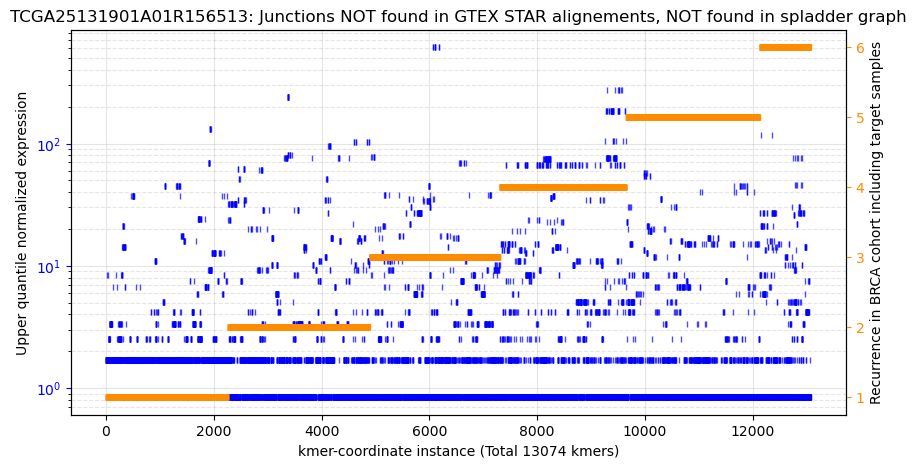

In [82]:
data_plot = df_filtered_info.loc[df_filtered_info['star_recurrence'].isna(), :]
expr_col = 'TCGA25131901A01R156513all'
recurr_col = 'cancerCohortfilter >0.0'
data_plot['index'] = np.arange(data_plot.shape[0])
idx = 'index'
sample = expr_col.replace('all','')
title = f'{sample}: Junctions NOT found in GTEX STAR alignements, NOT found in spladder graph'

plot_rec(data_plot, idx, expr_col, recurr_col, title)

Text(0.5, 1.0, 'Recurrence GTEX STAR of junctions pruned later in graph')

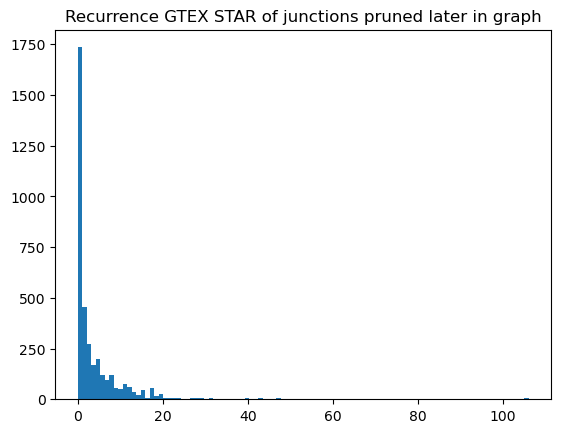

In [78]:
plt.hist(df_filtered_info['star_recurrence'], bins = 100)
plt.title('Recurrence GTEX STAR of junctions pruned later in graph')

In [31]:
df_filtered_info[df_filtered_info['star_recurrence'].isna()].shape

(13074, 35)

In [32]:
df_filtered_info[~df_filtered_info['star_recurrence'].isna()].shape

(3693, 35)

In [34]:
df_filtered_info[~df_filtered_info['star_recurrence'].isna()].shape[0]/df_filtered_info[df_filtered_info['star_recurrence'].isna()].shape[0] * 100

28.246902248737953

In [86]:
df_filtered_info.shape

(16767, 35)

In [2]:
16755  - 16767

-12

In [3]:
3600/ 13074

0.27535566773749426

In [ ]:
### CAREFUL USELESS BECAUSE I ALSO INCLUDED THE JUNCTIONS FOUND IN SPLADDER GRAPH 

In [1]:
len(df_filtered_info['kmer'].unique())

NameError: name 'df_filtered_info' is not defined

In [81]:
def plot_rec(data_plot, idx, expr_col, recurr_col, title):
    marker_size = 4
    color1 = 'blue'
    color2 = 'darkorange'
    color4 = 'green'
    colorgrid = 'grey'
    alpha_marker1 = 0.7
    alpha_marker2 = 0.5
    alpha_bar = 0.3
    alpha_grid = 0.2

    # Figure initialize 
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()


    # Ax 1
    data_plot.plot(x=idx, y=expr_col, ax=ax, legend=False, marker='|', alpha=alpha_marker1,
            linestyle = 'None', markerfacecolor=color1, markeredgecolor=color1, markersize=marker_size)
    ax.set_ylabel('Upper quantile normalized expression')
    ax.tick_params(axis='y', colors=color1)
    ax.grid(b=True, which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
    ax.grid(b=True, which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)

    # Ax 2
    data_plot.plot(x=idx, y=recurr_col, ax=ax2, legend=False, marker="|", alpha=alpha_marker2,
                  linestyle = 'None', markerfacecolor='None', markeredgecolor=color2, markersize=marker_size)
    ax2.set_ylabel('Recurrence in BRCA cohort including target samples')
    ax2.tick_params(axis='y', colors=color2) #, labelsize=14)

    # All plots
    ax.set_xlabel(f'kmer-coordinate instance (Total {len(data_plot)} kmers)')
    ax.set_yscale("log")
    #ax2.set_yscale("log")
    
    #ax.figure.legend()

    plt.title(title)
    # save = False
    # name = 'Recurr_expr' + suffix
    # save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
    # if save:
    #     print("save to {}".format(save_path))
    #     plt.savefig(save_path, bbox_inches='tight')

    fig.show()

In [72]:
def plot_rec2(data_plot, idx, expr_col, recurr_col, title):
    marker_size = 4
    color1 = 'blue'
    color2 = 'darkorange'
    color4 = 'green'
    colorgrid = 'grey'
    alpha_marker1 = 0.7
    alpha_marker2 = 0.5
    alpha_bar = 0.3
    alpha_grid = 0.2

    # Figure initialize 
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()


    # Ax 1
    data_plot.plot(x=idx, y=expr_col, ax=ax, legend=False, marker='|', alpha=alpha_marker1,
            linestyle = 'None', markerfacecolor=color1, markeredgecolor=color1, markersize=marker_size)
    ax.set_ylabel('Upper quantile normalized expression')
    ax.tick_params(axis='y', colors=color1)
    ax.grid(b=True, which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
    ax.grid(b=True, which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)

    # Ax 2
    data_plot.plot(x=idx, y=recurr_col, ax=ax2, legend=False, marker="|", alpha=alpha_marker2,
                  linestyle = 'None', markerfacecolor='None', markeredgecolor=color4, markersize=marker_size)
    ax2.set_ylabel('Recurrence in GTEX cohort (STAR)')
    ax2.tick_params(axis='y', colors=color4) #, labelsize=14)

    # All plots
    ax.set_xlabel(f'kmer-coordinate instance (Total {len(data_plot)} kmers)')
    ax.set_yscale("log")
    ax2.set_yscale("log")
    
    #ax.figure.legend()

    plt.title(title)
    # save = False
    # name = 'Recurr_expr' + suffix
    # save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
    # if save:
    #     print("save to {}".format(save_path))
    #     plt.savefig(save_path, bbox_inches='tight')

    fig.show()